# Exercise 3: Neutrino oscillation fit

Fitting experimental data is a vital skill for any practicing scientist. In this exercise you will analyse results from a real experiment and learn how to produce a parameter fit.

<div class="alert alert-block alert-info">
<h3>This exercise will cover:</h3> 
</div>

 * Finding the best value of a parameter by minimising a cost function (or objective function), another very common problem in data analysis and in training most Machine Learning algorithms.
 * Analysing publicly released data from a real particle physics experiment.
 * Loading tables of data from a file
 * REproducing a particular style of plot with `matplotlib`
 * Making use of library functions `minimize_scalar` from `scipy`
 * How to report an error on a measurement made by numerical fitting.

<div class="alert alert-block alert-info"></div>


## The experiment

We will be taking a look at the Reactor Experiment for Neutrino Oscillation (RENO). The experiment consists of two detectors, placed at different distances from a cluster of six nuclear reactors. The smaller "near" detector sits around 300m from the nearest reactor, while the larger "far" detector is more distant at 1400m away. The near detector is used to make a prediction of what would be seen at the far detector; the difference from this is attributable to oscillations.

The oscillation manifests as electron antineutrinos ($\bar{\nu}_e$) turning into other types (muon or tau antineutrinos) as they radiate away from the reactor. The detectors are not sensitive to these other types, so we only see the neutrinos that "survive" as $\bar{\nu}_e$. Quantum mechanically, each neutrino has a probability (called the *survival probability*) to remain as $\bar{\nu}_e$ , which can be expressed in a simple model as:

$$ P(\bar\nu_e \rightarrow \bar\nu_e) = P_\mathrm{e\rightarrow e} = 1 - \sin^2 \! {2\theta} ~ \sin^2 \! \Big({1.267 \cdot \frac{\Delta m^2 L}{E}} \Big)$$

(where the $1.267$ is the appropriate numerical factor if $L$ is in meters, $E$ in MeV, and $\Delta m^2$ in eV<sup>2</sup>/c<sup>4</sup>)



This equation can look a bit intimidating the first time you see it.  It has two sine functions in which is a bit alarming, but in practice it is not so complicated. 

The first trick is that $\theta$ is a number, a property of the neutrino system that we want to measure.  And because $\theta$ is just a number, so too is $\sin^2{2\theta}$.  We can just as easily set out to measure $\sin^2 2\theta$ and not worry about $\theta$, the data looks the same no matter how we describe it.  So we could instead have written:

$$ P(\bar\nu_e \rightarrow \bar\nu_e) = P_\mathrm{e\rightarrow e} = 1 - A ~ \sin^2 \! \Big({1.267 \cdot \frac{\Delta m^2  L}{E}} \Big)$$

and announced that we were trying to find $A$. Likewise, as used above, the cluster of symbols $\Delta m^2$ is also just a number.  In the real experiment this is also a measurable property of neutrinos (all neutrinos, not just the ones in our experiment) that we don't know accurately and would like to measure. But for the sake of making this project fit into time, we'll just pretend that we do know it accurately. 

<div class="alert alert-block alert-info">
So why do we the expression write it with $\sin^2 2\theta$ and not $A$, and $\Delta m^2$ instead of, say, $D$?  Well, clearly they do actually mean something.  
    
The angle $\theta$ is perhaps the easiest to understand.  Our electron neutrinos ($\nu_e$) are made up of two quantum eigenstates which well call $\nu_1$ and $\nu_2$:  
    $$ \nu_e = \alpha_1 \nu_1 + \alpha_2 \nu_2 $$
    Although we don't know what the alphas are we <i>normalise</i> our eigenstates so that it must be that $\alpha_1^2 + \alpha_2^2 =1$.  This is just the equation for a point on a unit circle and we know *that* can be described by a single angle - this is $\theta$
    
The $\Delta m^2$ is a bit more tricky.  It's actually shorthand for $m_2^2 - m_1^2$,  where the $m$ are the masses of the two neutrinos. This is is in some loose sense a measure of how fast time flows for the two relativistic neutrino states $\nu_1$ and $\nu_2$, in their rest frames.  Or rather, it's  the difference between them. Which is weird when you remember that they are two components of the same neutrino: $\nu_e$.  Tantalising, but relativistic quantum mechanics is a big subject, and we'll have to leave it there.  
</div>

<div class="alert alert-block alert-warning">
<h3>Check your understanding</h3>
</div>

Try to make sense of this probability function.  We will be looking at data with lots of different energies, so try to get an idea of how it looks like as a function of of $E$, with everything else held constant. Try the substitution $z = \Delta m^2 L/E$ and try to answer:
 1. What value does it take when $z$ is small?
 1. What value does it take when $1.267 \cdot z = \pi/2, \pi, 3\pi/2$?
 1. Hopefully you've convinced yourself this is an oscillating function. What is the (maximum to minimum) amplitude?
 1. If we write it in terms of $E$ again, does the amplitude change?

<div class="alert alert-block alert-warning"></div>


## Part 1: Reading the data

The data is provided in the `neutrino/reno.dat` text file. It contains the following five columns:

1. `EMin` - the start of an energy range.
2. `EMax` - the end of an energy range
3. `Data` - the number of candidate events registered in the far detector
4. `DataErr` - error on the data
5. `PredNoOsc` - predicted number of events if no oscillations occurred 

### Reading in a file

The Python standard library provides an `open()` function which is used to open files given a filename. There's a lot going on behind the scenes: finding the file on disk, making sure the data appears in the computers working memory, releasing control of that spot on the disk when you are done.  Luckily all everything we need to do is handled by the operating system and Python knows how to interpret any errors that might occur.  Everything can be wrapped up neatly using the  `with` keyword:

In [1]:
# Prints out the contents of example_text.txt
with open("/data/examples/p3/itlab/neutrino/example_text.txt") as f:
    print(f.read())

# Meaning of with:  If open("neutrino/example_text.txt") works
# 1. assign it's output to the variable f
# 2. try to do everything in the indented section
# when the program leaves the with block, `f` is closed safely, whatever happened. So we can't misuse the file.

Congratulations, you've opened a file succesfully. Neat!



That opened the file, but if we apply the same process to the data file `"/data/examples/p3/itlab/neutrino/reno.dat"` all it's going to do is print out the text of the file. (Try it.) We could go back to th regexps from exercise 1: start trying to find the numbers in the strings, converting them to floating point numbers.... but luckily there are easier ways.

The first is that numpy provides its own function for reading in an array of data from a text file, provided it obeys a standard format. You can use `np.loadtxt()` by supplying the filepath (and other optional arguments, see the [relevant documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html)).  If you printed out the file you'll have seen that the it has comments at the top explaining a bit about what the data is and the format of the columns. 

A more powerful alternative is the `pandas` library, which you can [find out about here](https://pandas.pydata.org/).  Pandas is not part of this course, but it is a commonly used tool in the Python community, and if you can use it if you like.  It's not especially difficult, but be warned that the demonstrators are not required to be familiar with it, so you are on you own. 



<div class="alert alert-block alert-success">
<h3>Computing task: Importing the data</h3>
</div>

Import the RENO data using `np.loadtxt()` (or some other method) and have a look at the arrays representing the columns of the file: <BR>`Emin` `Emax` `Data` `DataErr` and `PredNoOsc`.
 * Check you have imported the data correctly by comparing you arrays to the columns of the original file.  (You can do this 'by hand' by printing both out). 
 * What are the units of the five quantities? Read the data file if you aren't sure.
 * It will be useful to define some other quantities for each range:  The centre points of the energy range (which we will use when we need a value for $E$), and the width of the range. Calculate these arrays from Emin and Emax.

<div class="alert alert-block alert-success"> </div>

## Part 2:  Making some plots
Part of this exercise is producing a good looking plot of the data. In particle physics a lot of experimental data is in the form of "how often does some event happen as function of some other variable". 
> This is true in many other fields as well. For example, the spectrum of a star's light is nothing more than "how many photons are observed, as a function of the photon energy/frequency/wavelength". But particle physics experiments are sufficiently big and expensive that you can't easily repeat a measurement. So we have to be careful about the statistical variations associated with counting things. 

The practical upshot is that plots of results very often take the form of a histogram.  We divide the variable of interest up into bins, and record how often events 'land' in each bin.  Do this enough and you get a distribution that should match the rate at which the events happen.  The real craft of the experimenter is making sure you understand - and can estimate quantitatively - how much your limited dataset might reasonably diverge from the measurement you would make if you had infinite time and money.  Then you can compare what you actually see to a *model* of the phenomenon and tweak the model until you get good agreement with the data, within the uncertainty imposed by your limited dataset.

In the RENO experiment, the "data" is those events recorded from the far detector ordered by their energy, while our "model" is that the data will follow the predicted rate (which comes from analysing the near detector), scaled it by the survival probability, $P_{e\rightarrow e}$.  You can see this in Figure 2 of the [journal paper](https://inspirehep.net/record/1676077) (click "pdf" and then "arXiv") we took the data from.  The first thing we will try to do is recreate (a simplified version of) this figure.

### Making a histogram of the prediction
You might rememeber making a histogram in the P2 lab (if not you can check it in `examples/p2/Exercise 08 - Data Files and Statistics`).  What we need to do this time is slightly different.  You see from the data file we actually have a summary: each line describes a single bin of the histogram.  It has the minimum and maximum edges of the bin, the number of events observed, with the error on that number, and the prediction of what to expect without applying the survival probability.

We'll first make a histogram of the prediction. Looking at the [histogram documentation](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.hist.html), PyPlot (`plt.hist`) is going to want a list of bin edges which we almost have:  `Emin` and `Emax` give us all the edges, but the first edge is only in Emin and the last is only in Emax.  So the first thing to do is combine those two lists into a single list of bin edges.  Your combined list should be one element longer than the two lists separately.  (You can do this manually by typing the new list in, but can you find a neat way to combine the two?)

Once you have the list of bin edges, you need to fill them with the `PredNoOSc` values.  In P2 we filled each event as it came in, but here we just have the totals for each bin. You could perhaps just write a loop to fill each bin the right number of times, but if you look carefully this isn't going to work.  The problem is that there's a background contribution which has been estimated and subtracted off each bin (to make the problem simpler), which leaves us with fractional numbers of events(!).  Luckily, there a faster way to fill the histogram that also gets round the 'fractional events' problem. You can fill one event in the centre of each bin, but the event is *weighted* to the prediction by using the keyword argument `weights=`, which you which you can pass the prediction to.  

### Plotting the data points 
The actual data is plotted slightly differently.  We could plot `Data` the same way we plotted `PredNoOsc` (you can try it), but we want to show that experimental uncertainty (`DataErr`) as well.  The almost-universal convention in the field is to show the data as markers at the right height, half-way between the edges of the bin, and add error bars showing this uncertainty.  The problem is that `plt.hist` doesn't give us this option, we have to use `plt.errorbar` (find it on the [pyplot documentation](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.html)).  In this case, instead of bins edges and weights, we need to give it arrays of the marker positions, and of the size of the *x* and *y* error bars.  The *x* error bars should be half the width of the bins (i.e. the distance from the centre to the edge), and the *y* error bars show `DataErr`.

<div class="alert alert-block alert-success">
<h3>Computing task: Reproducing the figure </h3>
</div>

1. Make a plot similar to the top part of Figure 2 in the [journal paper](https://inspirehep.net/record/1676077).  You should start by plotting the no-oscillation prediction as described above, and then on the same axes plot the data with errors.
2. Make you plot look as good as you can. It should definitely have axis titles, but see if you can add a legend as well.  You might also tweak the line width, and see if you can add markers on the data points, like the original has.  If you want to have a simple line rather than a filled histogram, there is an option for that - check the documentation.  

<div class="alert alert-block alert-success"> </div>


## Part 3: Fitting the data

Fitting can be viewed as a computational *minimization* problem. What we need is an *objective function* that describe the difference between the model and the data, and has the property that it takes large positive values when they are different and is zero when they are the same.  Let's call the model $M(x)$ where $x$ is the model parameter(s).  Then if we define an objective function $S^2(M(x))$, that gives us in effect, a function of the parameter(s) $S^2(x) = S^2(M(x))$.  Then we can just find the minimum of $S^2(x)$ (e.g. by finding where $d(S^2)/dx = 0$) and this value of $x$ will be the one where the model best matches the data. 

There are a few such objective functions that can be used, but the most common is the $\chi^2$, (the Greek lower-case chi, pronounsed "*kai*" in English, but not in Greek), defined as

$$S^2(x) \rightarrow \chi^2(x) = \sum_i^{n_\mathrm{bins}} \frac{\big(D_i - M_i(x)\big)^2}{\sigma_i^2}$$

where $D_i$ and $\sigma_i$ are the number of events in bin $i$ and its associated error, and $M_i(x)$ is the model prediction for the same bin.  We then define the model we described above: 
$$ M_i(\sin^2 2\theta) = P_{e\rightarrow e} (E_i;\sin^22\theta) \cdot O_i$$

where $O_i$ is the non-oscillated ("Original") prediction. Finally we can minimise the objective function to get something that will tell us the best value of $\sin^22\theta$.

This is where the computer comes in.  It's not too hard to write down the model $M(x)$ and the objective function $\chi^2(x)$ as maths, but actually finding the minimum with pen and paper is a lot of differentiation that we really don't want to do.  Instead, the computer (specifically the SciPy libraries) provide ways to find a minimum, essentially by repeatedly evaluating a function at a few points and moving in the direction of the smallest one.

<div class="alert alert-block alert-warning">
<h3>What do we expect to get? </h3>
</div>

We are going to get the computer to do quite a lot of calculations that we are never going to be able to check. As the problem gets more complicated a few things become increasingly important: 
 * Break the problem up into simple pieces (simple enough that you can look at and understand) as much as possible.
 * Test each piece to see if the do what you expect
 * Work out roughly what result you expect from solving the full problem.  
 
You now know everything that will go into the fit. So you can make an attempt at that third thing: estimate what a reasonable value for the result might be. If you worked out the amplitude of the survival probability, have a look at the plot you made of the data and and the no-oscilaltion prediction. Can you estimate roughly what value of the fit parameter $\sin^22\theta$ would make the two agree well? (You should be able to judge it by eye, no need to measure or do any complicated calculations.)  

Even if you aren't confident in guessing what the fitter should come up with, try to answer the opposite question: What values would definitely be *wrong*? <BR> *Hint: remember the parameter we're want to get from the fit is $\sin^2 2 \theta$.*

<div class="alert alert-block alert-warning"></div>



### The minimiser

To minimise the function we'll use the `minimize_scalar` [function](https://docs.scipy.org/doc/scipy-1.5.0/reference/generated/scipy.optimize.minimize_scalar.html), which is specifically for problems with only one variable.  This requires only one argument: the objective function $S^2(x)$. Here's the example, modified from the SciPy documentation page:

     fun: 0.0
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 13
     nit: 9
 success: True
       x: 0.0


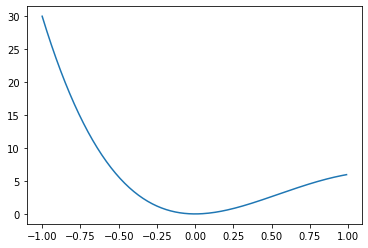

In [2]:
from scipy.optimize import minimize_scalar

X_OFFSET_VALUE = 2.
Y_SCALE_VALUE = 2.

def example_objective(x, offset, scale):
    """
    Some function to minimise. The first argument is the variable we want to mimimise over. 
    The others stay constant during the minimisation
    """ 
    # Yes, it looks nothing like a chi-squared function. The minimiser is a general tool, 
    # applying it to a chi^2 is what makes our problem a fitting problem specifically. 
    u = x - offset
    return scale * (u-2) * u * (u+2)**2   

    
# run the minimiser    
result = minimize_scalar(example_objective, args=(X_OFFSET_VALUE, Y_SCALE_VALUE))
#   The args=() is a tuple of variables that will be passed on (in order) to the objective function.  


#print the results. 
#result.x is the thing we actually care about, although it's important that result.sucess == True
print(result)



#check if result.x really is a minimum 
import matplotlib.pyplot as plt
import numpy as np

scan_x = np.arange(result.x-1, result.x+1,0.01) 
scan_y = example_objective(scan_x, X_OFFSET_VALUE,Y_SCALE_VALUE)
plt.plot(scan_x, scan_y)
plt.show()

The `args` argument of the minimiser function is very useful.  Although the minimiser will only search for the minimium of the objective function with respect to its first argument, you might want to pass in other parameters to a more general function.  In the example these are just to shift and scale the function, but in the case of fitting this would be a good way to supply all the data and other things you need calcualte the objective function.  The neat thing about `args=` is that you give it a tuple, so it can be used to provide any number of arguments to the objective funtion


<div class="alert alert-block alert-info">
    In general minimisers (or minimizers in American<sup>1</sup>) can operate over many unknowns at once: In the original analysis, the RENO experiment actually fit for $\Delta m^2$ at the same time.   The <b>minimize_scalar</b> utility can be much faster and more reliable because it only has to search in one direction (think about looking for a dropped wallet on station platform vs looking for it on a football pitch).  
    
In 2 dimensions and higher, minimisers often need some help in the form of a initial guess.  This is another reason why making an estimate of the answer before running the code can be useful. The one-dimensional minimiser does not need this hint, although it sometimes needs to be given two values that <i>bracket</i> the answer.  If you worked out allowable limits on $\sin^22\theta$, you could try giving those to the function.    
    
<sup>1</sup> As noted earlier, Python uses US English.  It's <i>minimizer</i> the same was as it's <i>color</i>.  As a British English speaker, my advice is that you should do the same when writing code.  After a decade, it's a still looks wrong to me, but the confusion of switching between British spellings for your own functions and US spellings if it came from a library is a real problem and can literally cost you days in a big project.
</div>

<div class="alert alert-block alert-success">
<h3>Computing task: Writing a fit </h3>
</div>


To fit the data you need to write an objective function for the minimiser to minimise.  Each time the function is called with a new value of $\sin^22\theta$ you'll need to recalculate  the survival probability to evaluate the model - that should be another function.  

You'll also need to use the various arrays  (`Data` etc) inside the objective function.  Jupyter does allow you to define these as global variables and just use them directly, but this is considered bad programming style: you need to keep track in your head of everywhere you use them and this gets *really* difficult as the project get larger.  Much better to pass them in at the top of the function, so that it tells you right there what it will use.  So get into good habits and write the objective function so gets everything it needs from it's arguments.

To calculate the survival probability $P_{e\rightarrow e}$ you should use particular values of the other constants:  The baseline $L$ is $1400\,\text{m}$, and you can assume $\Delta m^2 = 2.68 \times 10^{-3}\,\text{eV}^2/c^4$.   There are several ways you could introduce these constants into your program, and there's not one right answer here (although there are wrong answers). Try to justify your choice. 

Use the minimizer to find the best fit for the data. What values did you get? 

<div class="alert alert-block alert-success"></div>


## Part 4: The fit result
If the fit was perfect, we would have 
$$
    D_i - P_{e\rightarrow e} (E_i) \cdot O_i = 0\\  \quad \Longrightarrow \quad  P_{e\rightarrow e} (E_i) = \frac{D_i}{O_i} 
$$
when we use our best fit value of $\sin^22\theta$. We can use this ratio to see how well the fit worked in practice.  

<div class="alert alert-block alert-success">
<h3>Computing task: Plotting the result </h3>
</div>

Plot the ratio $D_i/O_i$, remembering that the $D_i$ points have errors that you can propagate to the ratio.  You can overlay on this the probability calculated with your best fit value of $\sin^22\theta$, (`plt.plot` is fine for this). It should line up reasonably well if everything has worked.

*The data does not match the fit quite so well at low energies - this is due to how we have simplified the fitter. The real analsyis is much more complicated!*   

<div class="alert alert-block alert-success"></div>


### Parameter errors from Chi2 fits

The error bars on the data mean that the value of $\sin^22\theta$ (and therefore the survival probability) has some uncertainty. A useful feature of the $\chi^2$ objective function is that it can be used to calculate the correct error on the fit result.  The standard error on the fit result can be found by following the following recipe:

1. Calculate the minimum $\chi^2$ - the value that corresponds to your best fit $\sin^2{2\theta}$ (*The minimiser result stores this, but you can also quickly recalculate it*)
1. For any value of $\sin^22\theta$ other than the best fit value the $\chi^2$ should be higher, because the best fit point is the minimum.
1. When the value of $\chi^2$ increases by one unit, these are the edges of the error band


<div class="alert alert-block alert-success">
<h3>Computing task: Obtaining the error </h3>
</div>
To follow the above recipe visually 

1. Get $\chi^2_\text{min}$ from your fit. 
1. Plot $\chi^2 - \chi^2_\text{min}$, with $\sin^22\theta$ on the x-axis.  Tweak the plotting range so that the y-axis only goes up to about 4 (*the minimum should be at y=0 by construction.*) 
1. Where this function crosses the line y=1, is the two edges of the error band. So we can say the error on $\sin^22\theta$ is half the distance between these points.  What error do you get?   
(*If you are short of time just do this 'by eye' to see how you did, but if you have a bit more time, see if you can write a piece of code to calcualte the error properly*) 


### Comparing to the official analysis
If you're wondering how well you did, the original analysis by the RENO collaboration is [here](https://inspirehep.net/record/1676077), and you can find their answer for $\sin^22\theta$ (They give it labels $\theta_{13}$ but it's basically the same angle) in the abstract.   Their full analysis also considers systematic uncertainties, which we have ignored.  But this fit uses exactly the same data so it should come out with a similar value, and a similar error.  

<div class="alert alert-block alert-success"></div>
